类别权重： {0: 0.9999958333333333, 1: 1.0000041667013893}


C:\Users\李凯航\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [14:29:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.84      0.93      0.88     50000
           1       0.92      0.82      0.87     50000

    accuracy                           0.87    100000
   macro avg       0.88      0.87      0.87    100000
weighted avg       0.88      0.87      0.87    100000



E:\app\anaconda\anaconda-con\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\app\anaconda\anaconda-con\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\app\anaconda\anaconda-con\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\app\anaconda\anaconda-con\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


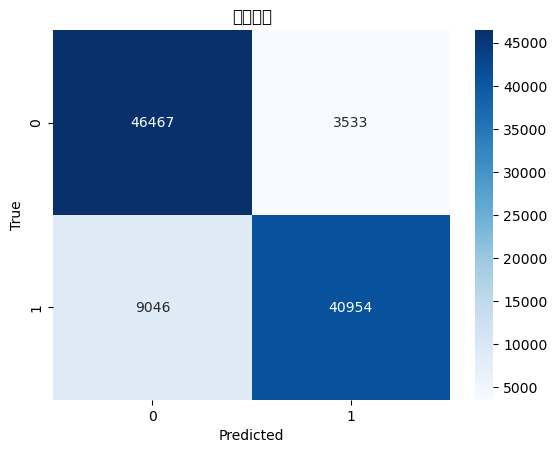

In [7]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack, csr_matrix

def extract_features(url): #结构化特征，优化使用
    features = {} #创建空字典
    url = str(url) #确保url都是字符串
    features['url_length'] = len(url) # 看长度
    features['count_dots'] = url.count('.') #看点的数量
    features['count_hyphens'] = url.count('-') #看横杠的数量
    suspicious_keywords = ['login', 'secure', 'account', 'verify', 'password', 'update', 'banking'] #看敏感词在恶意网站中的敏感词
    features['count_suspicious_words'] = sum( #这里是数组的原因是我们的url不止一个
        1 for kw in suspicious_keywords if kw in url.lower()
    ) #遍历一遍看有多少敏感词，统计出来个数2
    return features

data=pd.read_csv('E:/作业/杂物/数据集/111_fixed.csv',encoding='ISO-8859-1')
data = data.dropna(subset=['url', 'label'])
data = data[data['url'].astype(str).str.strip() != '']
x=data['url']
y=data['label'] #加载数据
xx = pd.DataFrame([extract_features(u) for u in x])
vec=TfidfVectorizer() #创建向量器
x_vec=vec.fit_transform(x) #转化x
y_np = np.array(y)
weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_np),y=y_np)
class_weights = {i: weights[i] for i in range(len(weights))}
print("类别权重：", class_weights)#计算权重解决模型宁可错杀绝不放过的特征
scaler = MinMaxScaler()
structured_train_scaled = scaler.fit_transform(xx) #防止数据特征本身太大或太小太影响结果判断转换成介于(0,1)
structured_train_sparse = csr_matrix(structured_train_scaled) #转换成稀疏矩阵进行拼接因为前面 x_vec（TF-IDF 特征）就是稀疏矩阵必须跟它格式一样才能拼接！
x_final = hstack([x_vec, structured_train_sparse]) #合并数据将特征和数据本身进行合并变成一个
dtrain = xgb.DMatrix(x_final, label=y_np) 

params={
    'objective':'binary:logistic', #目标函数，我们明显是二分类用 binary:logistic
    'eval_metric':'logloss', #评估指标，这里用 logloss
    'eta': 0.05, #学习率，值越小越稳越慢默认0.1
    'max_depth': 8, #每棵树的深度，越深越复杂一般4-6复杂可到8
    'subsample': 1.0, #样本采样比例，防止过拟合
    'colsample_bytree': 0.8, #特征采样比例
    'scale_pos_weight': weights[1] / weights[0],  # 用之前计算出来的类别权重等于是正常样本/恶意样本
    'use_label_encoder': False, #用于类别不平衡调整，越接近真实比例越好
}  #不是特别理解好像就是不同的参数,感觉很难记住

bst = xgb.train(params, dtrain, num_boost_round=100)

data2=pd.read_csv('E:/作业/杂物/数据集/balanced_test_set.csv', encoding='gb18030')
x1=data2['url']
y1=data2['label'] #读取测试数据
xx1 = pd.DataFrame([extract_features(u) for u in x1])
x1_vec = vec.transform(x1) #测试数据也要使用相同向量器进行转化

structured_scaled2 = scaler.transform(xx1) #不用再fit了！！！我们应当使用之前的规则
structured_sparse2 = csr_matrix(structured_scaled2) #测试集数据也应该这样做
x_final2 = hstack([x1_vec, structured_sparse2]) 

dtest = xgb.DMatrix(x_final2)
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y1.values, y_pred))

cm = confusion_matrix(y1.values, y_pred) #可视化直观方便
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('混淆矩阵')
plt.show()